### HWNI Boot Camp - TMS introduction and demo 

The following jupyter notebook is a quick demonstration of how a TMS study is designed, implemented, and analyzed. 

#### You can 'run' each cell by pressing _shift_ and *return* at the same time 

In [1]:
# import python stuff 
import numpy as np
np.set_printoptions(precision = 3)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('precision',2)
import scipy.io as io
import scipy.stats as stats
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('white')
import glob
import nilearn
nilearn.__version__
from IPython.display import Image

/Users/jcbmiller/anaconda3/envs/python3_analysis_plotting/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Every study starts with a research question. Ours is below. The experimental task we gave participants was to remember a direction (*left / right / up / down*). While they remembered this direction, they had to perform a movement based upon the color shown. This movement could be in the same (comaptible) or different (incompatible) direction. 

In general, people are much less accurate and respond more slowly when movements are _incompatible_. We've called this the compatibility effect.

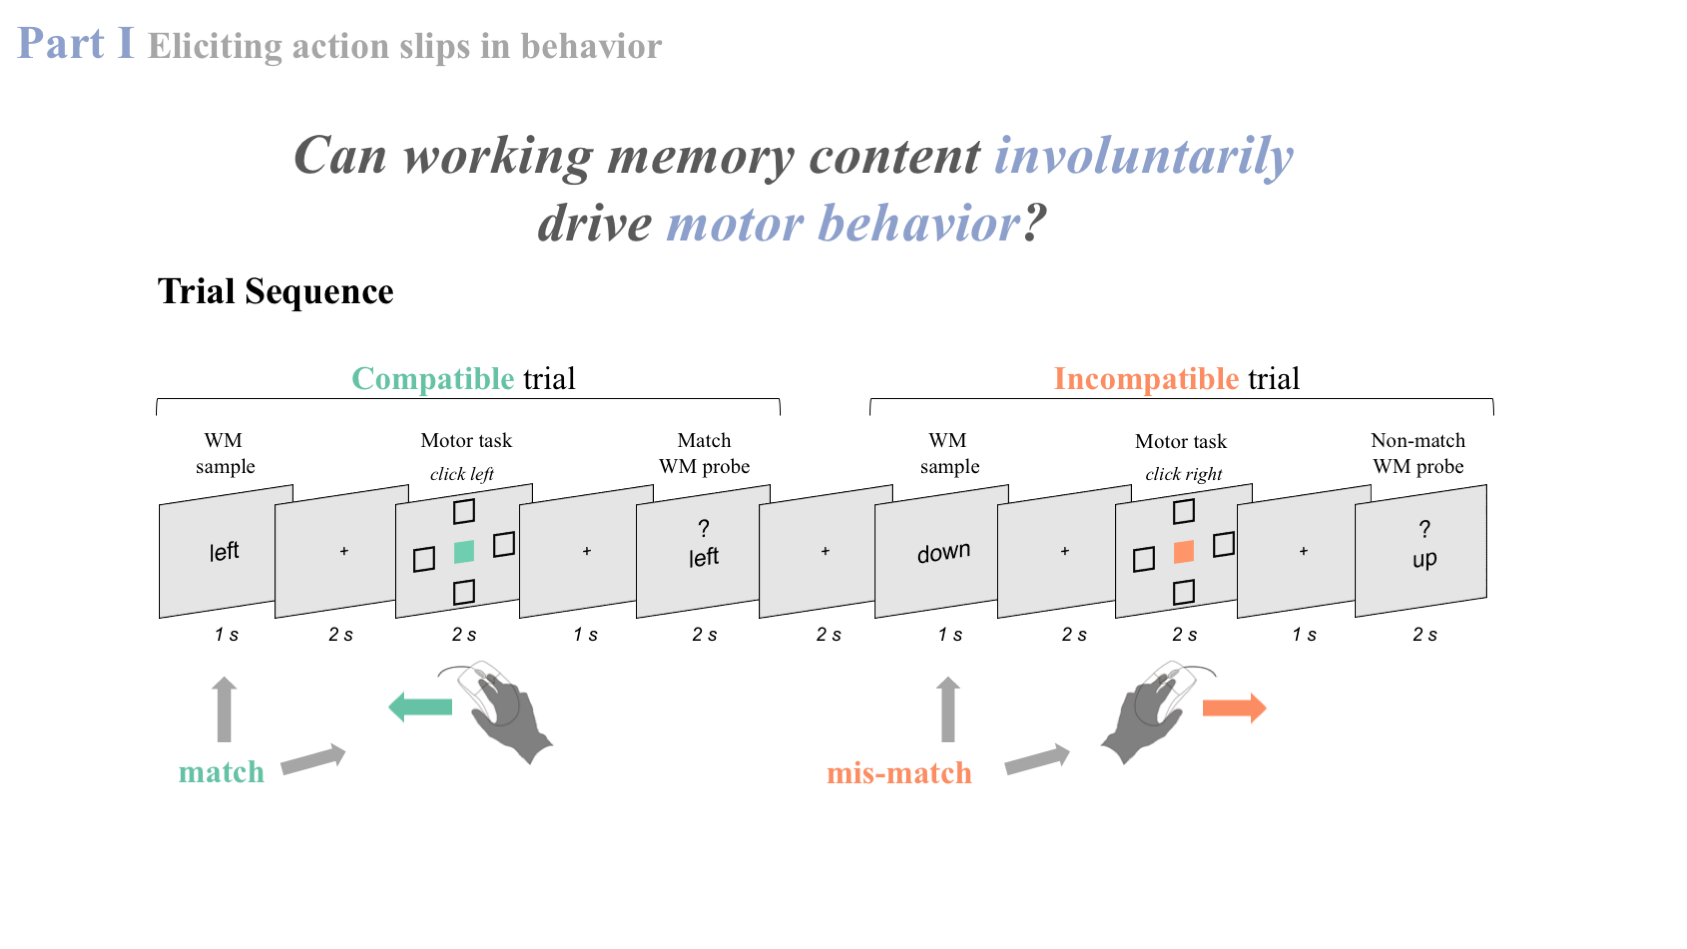

In [2]:
Image('figures/task.png')

We had participants perform 9 blocks of this task. In each of the blocks, the ratio of compatible to incompatible trials was different. The more compatible trials, the more likely, we think, people are to make mistakes, because the memory item is genrally useful. This is akin to a *Stroop* effect, but here the interference is between memory and action, as opposed to percpetion and language. 

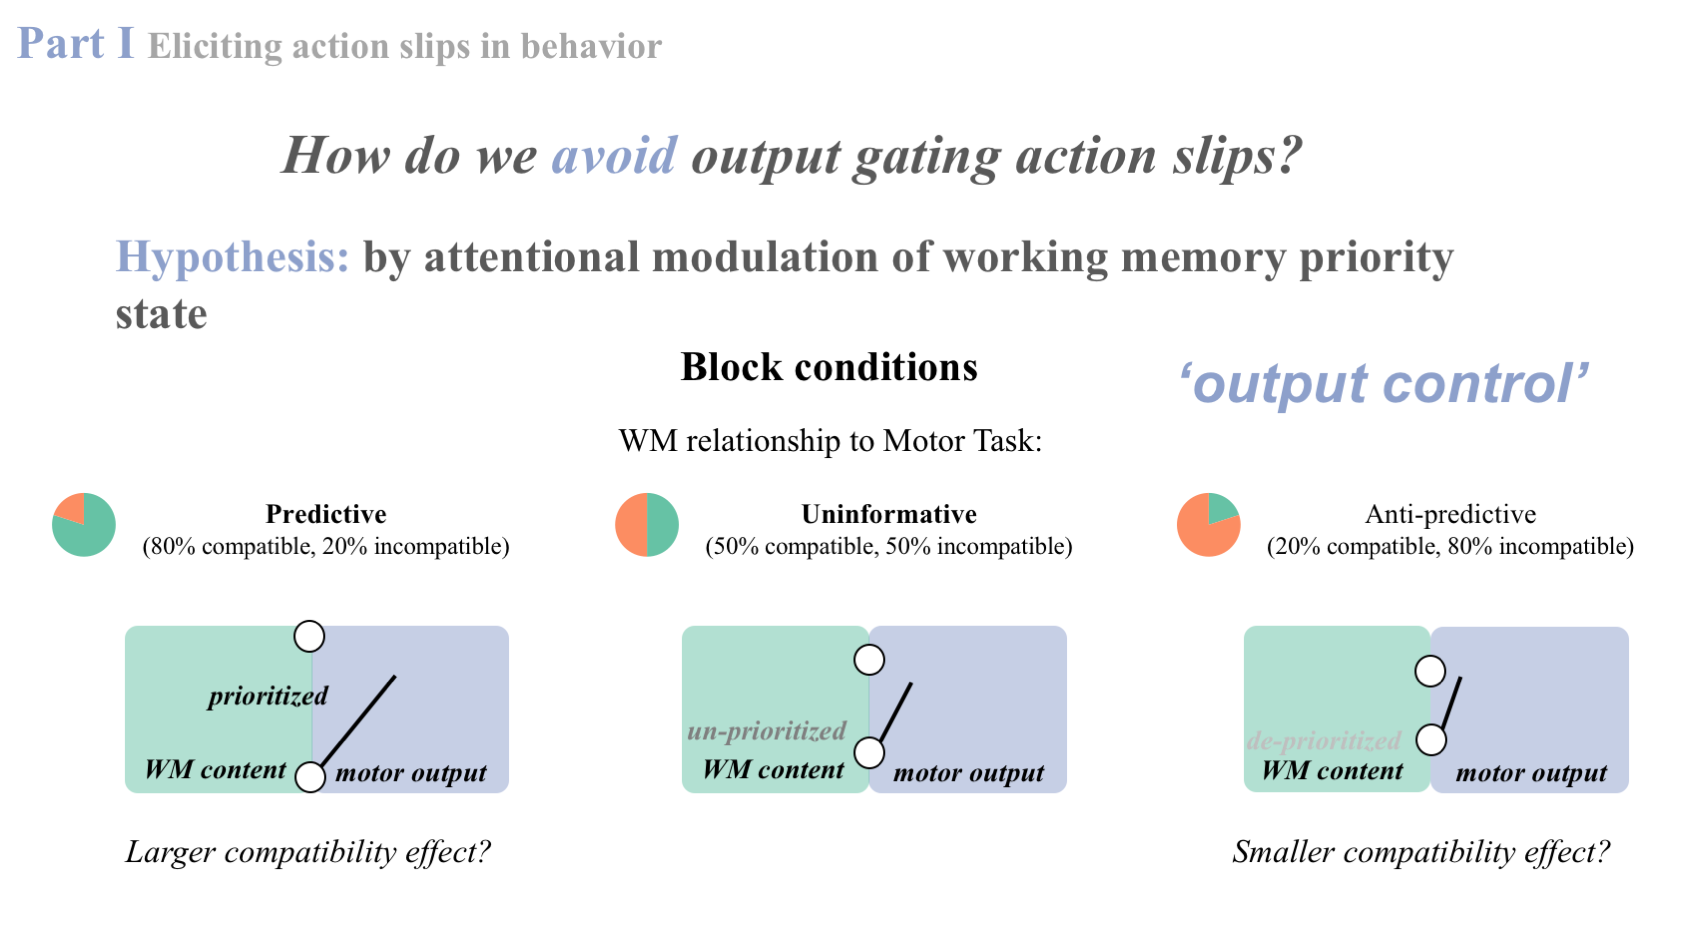

In [3]:
Image('figures/gating.png')

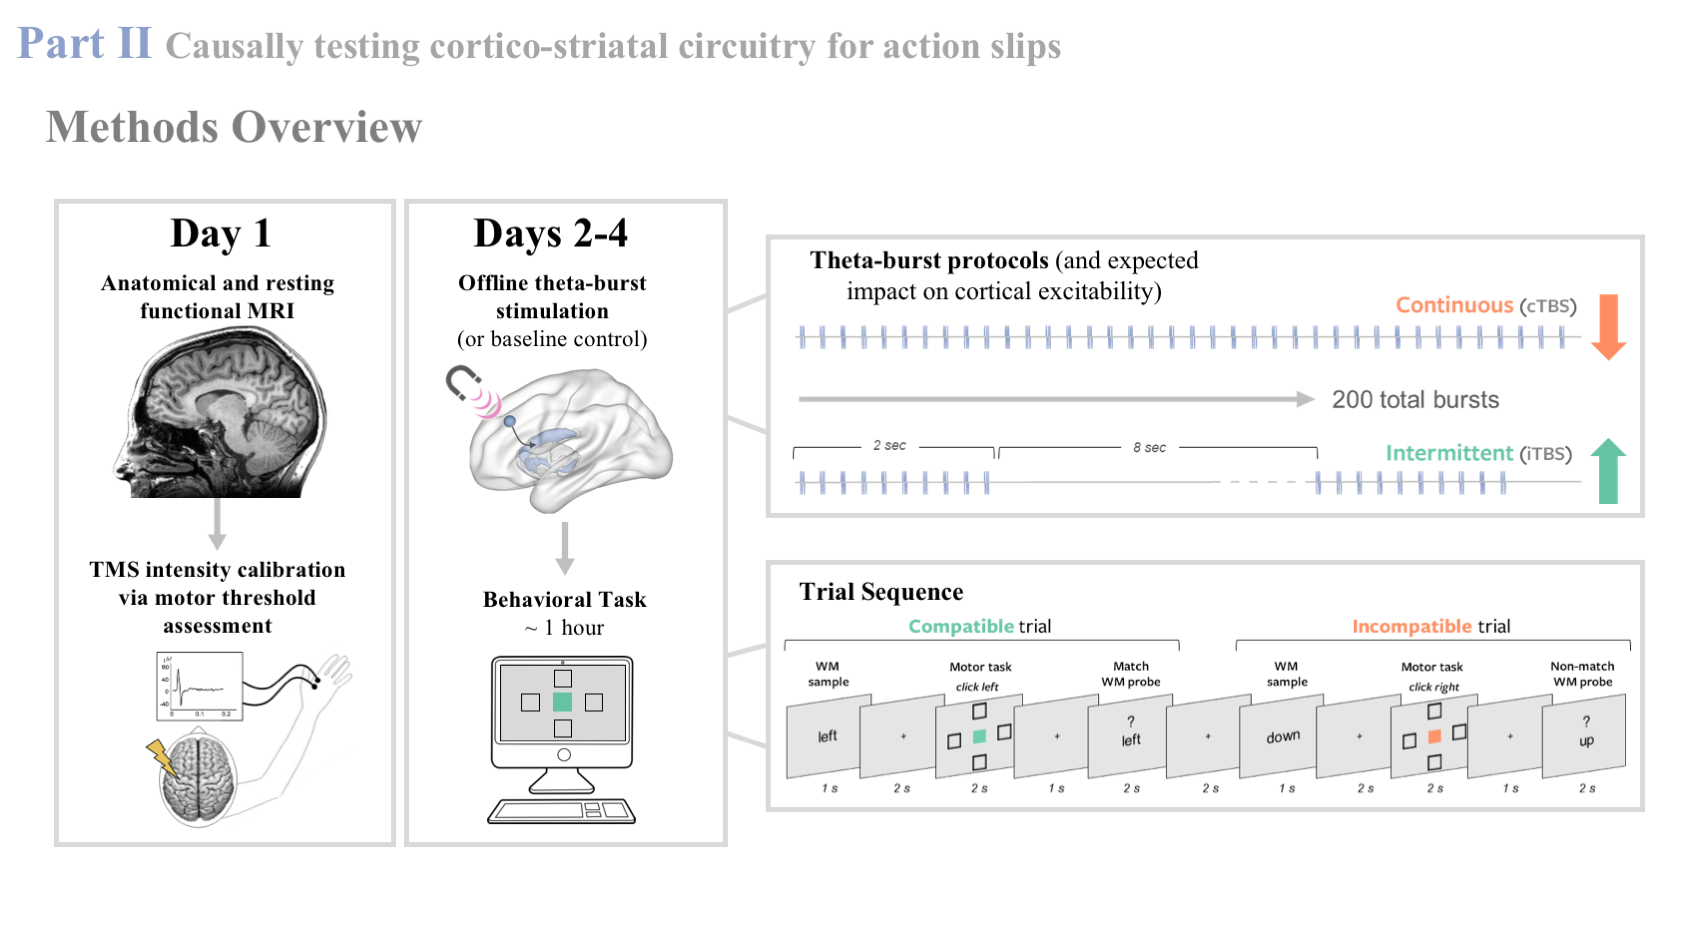

In [4]:
Image('figures/study_design.png')

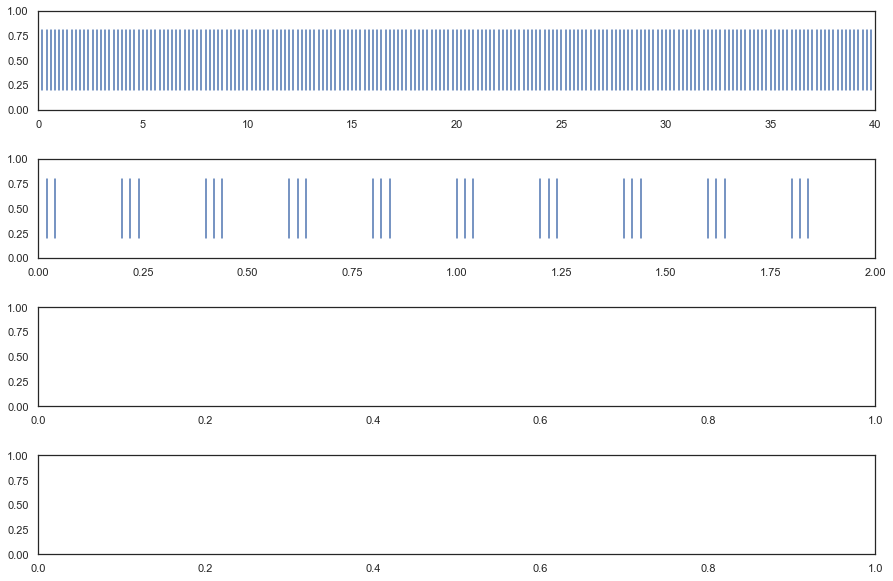

In [21]:
fig, ax = plt.subplots(4, figsize = (15,10))
plt.subplots_adjust(hspace=0.5)

cTBS_length = 40
n_bursts = 200
n_pulses = 600 

ax[0].set_xlim(0,cTBS_length)
for i in np.arange(0,cTBS_length,1/5):
    ax[0].axvline(x=i, ymin=0.2, ymax = 0.8)
    
ax[1].set_xlim(0,cTBS_length/20)
for i in np.arange(0,cTBS_length/20,1/5):
    ax[1].axvline(x=i, ymin=0.2, ymax = 0.8)
    ax[1].axvline(x=i+1/50, ymin=0.2, ymax = 0.8)
    ax[1].axvline(x=i+2/50, ymin=0.2, ymax = 0.8)

# ax[1].set_xlim(0,cTBS_length*5)
# for i in np.arange(0,cTBS_length*5):
#     ax[1].axvline(x=i, ymin=0.2, ymax = 0.8)
#     ax[1].axvline(x=i+1/50, ymin=0.2, ymax = 0.8)
#     ax[1].axvline(x=i+2/50, ymin=0.2, ymax = 0.8)

    

In [28]:
(1/50)*3

0.06

In [36]:
np.arange(0,3/50,1/50)

array([ 0.  ,  0.02,  0.04])

In [17]:
np.arange(0+k*8,cTBS_length/20+k*8,1/5)

array([152. , 152.2, 152.4, 152.6, 152.8, 153. , 153.2, 153.4, 153.6,
       153.8])

In [19]:
np.arange(0,cTBS_length/20,1/5) + 8

array([8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8])

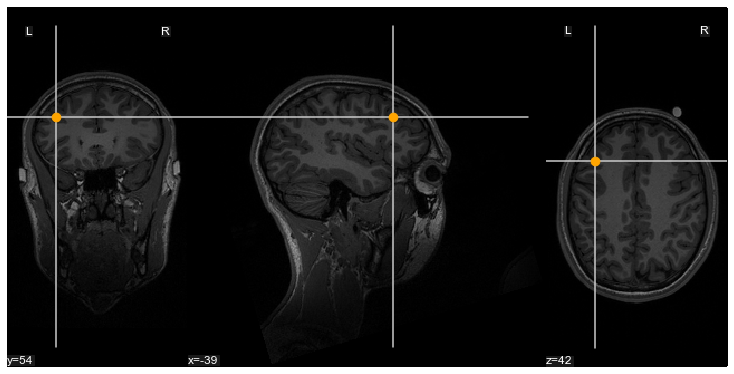

In [17]:
from nilearn import plotting, image
fig,ax = plt.subplots(1,figsize=(10,5))
display = plotting.plot_anat('figures/sub-127_T1w.nii.gz', display_mode = 'ortho',
                             cut_coords=(-39, 54, 42), figure=fig)
display.add_markers([(-39, 54, 42)], marker_color='orange', marker_size=75) 

### Loop through subject data and concatenate

In [38]:
subjects = ['OGWM_' + str(i) for i in range(101,127)] # OGWM_101 - OGWM_120
df_combined = pd.DataFrame() # empty DataFrame 
df_means = pd.DataFrame()
df_all_trials = pd.DataFrame()


In [39]:
# loop through and groupby compatibility and block to make new dataframe, 
#  from which a factor plot with variance can be plotted

# remove subjects if excluded
subjects.remove('OGWM_102')
subjects.remove('OGWM_120')
subjects.remove('OGWM_121')

TMS_sessions = ['no_TMS', 'PFC_cTBS', 'PFC_iTBS']


for sub in subjects:
    
    for TMS_session in TMS_sessions:
        
        # get filename for given TMS session
        fname = 'OGWM_word_SD_block_comp_TBS_{}_*_{}.txt'.format(sub,TMS_session)
        glob.glob(fname)
        fname = glob.glob(fname)[0]
        session = fname.split('_')[8]+'_'+fname.split('_')[9] # sess_1 / sess_2 / sess_3
        fname = 'OGWM_word_SD_block_comp_TBS_{}_{}_{}.txt'.format(sub,session,TMS_session)
    
        #fname = 'OGWM_word_SD_block_comp_{}.txt'.format(sub)
        df = pd.read_csv(fname, header = 0, sep = '\s+') # read in df for the subject
        # df = df[(df.ACC == 1) & (df.probeACC == 1)] # keep only correct trials 
        df = df[['subject','session','target','block','BlockType','TrialType','move_init_bound_msecRT', 'enter_box_msecRT', 'velocity_drop_msecRT', 'msecRT', 'ACC', 'probemsecRT', 'probeACC']]
        df['msecRT'] = pd.to_numeric(df['msecRT'], errors = 'coerce')
        df['move_init_bound_msecRT'] = pd.to_numeric(df['move_init_bound_msecRT'], errors = 'coerce')
        df['enter_box_msecRT'] = pd.to_numeric(df['enter_box_msecRT'], errors = 'coerce')
        df['velocity_drop_msecRT'] = pd.to_numeric(df['velocity_drop_msecRT'], errors = 'coerce')
        df['probemsecRT'] = pd.to_numeric(df['probemsecRT'], errors = 'coerce')

        # add column for corrected movements from text file for each sub 
        corrections_fname = 'OGWM_word_SD_block_comp_TBS_{}_{}_{}_corrected_movements.txt'.format(sub,session,TMS_session)    
        corrections_fname_1_4 = 'OGWM_word_SD_block_comp_TBS_{}_{}_{}_corrected_movements_1_4.txt'.format(sub,session,TMS_session)
        angles_fname = 'OGWM_word_SD_block_comp_TBS_{}_{}_{}_movement_angle.txt'.format(sub,session,TMS_session)    
        angles_fname_1_4 = 'OGWM_word_SD_block_comp_TBS_{}_{}_{}_movement_angle_1_4.txt'.format(sub,session,TMS_session)    
        df['corrected_movements'] = np.genfromtxt(corrections_fname)
        df['corrected_movements_1_4'] = np.genfromtxt(corrections_fname_1_4)
        df['movement_angle'] = np.genfromtxt(angles_fname)
        df['movement_angle_1_4'] = np.genfromtxt(angles_fname_1_4)
        df['movement_angle_difference'] = 180-np.abs(df['movement_angle'])
        df['movement_angle_difference_1_4'] = 180-np.abs(df['movement_angle_1_4'])
        df_combined = pd.concat([df_combined, df])

### Report subject accuracies for motor and probe responses

In [40]:
df_orig = df_combined
#df_combined

#### optional: analyze only blocks 1-6

In [41]:
#df_combined = df_combined[df_combined.block <7]

In [42]:
for sub in subjects:
    print(sub, list(df_combined.groupby(('subject')).get_group(sub).drop_duplicates(subset='block',keep='first').BlockType))

OGWM_101 ['neutral', 'valid', 'invalid', 'invalid', 'valid', 'valid', 'neutral', 'invalid', 'neutral']
OGWM_103 ['neutral', 'invalid', 'invalid', 'invalid', 'valid', 'valid', 'neutral', 'neutral', 'valid']
OGWM_104 ['neutral', 'valid', 'invalid', 'invalid', 'invalid', 'valid', 'neutral', 'neutral', 'valid']
OGWM_105 ['neutral', 'valid', 'invalid', 'neutral', 'neutral', 'valid', 'invalid', 'invalid', 'valid']
OGWM_106 ['neutral', 'valid', 'neutral', 'invalid', 'valid', 'invalid', 'valid', 'neutral', 'invalid']
OGWM_107 ['neutral', 'invalid', 'valid', 'invalid', 'valid', 'neutral', 'invalid', 'valid', 'neutral']
OGWM_108 ['neutral', 'valid', 'valid', 'neutral', 'invalid', 'invalid', 'valid', 'invalid', 'neutral']
OGWM_109 ['neutral', 'valid', 'valid', 'invalid', 'neutral', 'valid', 'neutral', 'invalid', 'invalid']
OGWM_110 ['neutral', 'neutral', 'invalid', 'neutral', 'valid', 'invalid', 'valid', 'valid', 'invalid']
OGWM_111 ['neutral', 'valid', 'neutral', 'invalid', 'invalid', 'valid', '

In [43]:
grouped_subject = df_combined.groupby('subject') # group by subject name 

In [44]:
grouped_subject[('ACC', 'probeACC')].aggregate(np.mean) # aggregate within group by passing np.mean function 

,ACC,probeACC
subject,,
OGWM_101,0.99,0.99
OGWM_103,0.99,0.98
OGWM_104,0.97,0.94
OGWM_105,1.00,0.99
OGWM_106,0.98,0.95
OGWM_107,0.99,0.96
OGWM_108,0.99,0.98
OGWM_109,0.99,0.98
OGWM_110,0.99,0.98


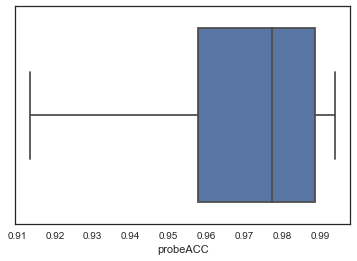

In [45]:
sns.boxplot(grouped_subject['probeACC'].aggregate(np.mean)) 

### Test accuracy measures before excluding incorrect trials

/Users/jcbmiller/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


T-test of ACC (compatible vs. incompatible subject means): 
 t = 1.7887921209141766 
 p = 0.07810223346084878


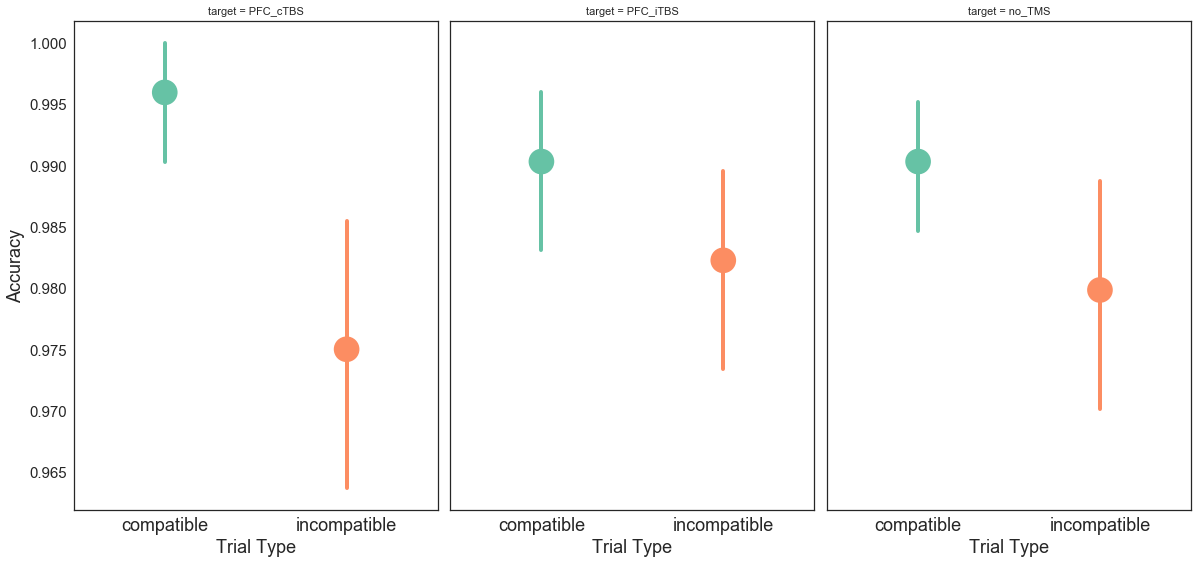

In [46]:
# plot accuracy by trial type 

size=8
fs=16

group_acc_plot = df_combined.groupby(['subject', 'target','BlockType', 'TrialType'], as_index=False).aggregate(np.mean).groupby('BlockType').get_group('neutral')

#g = sns.factorplot(x='TrialType', y = 'ACC', data = group_acc_plot, palette = 'Set2', kind = 'box', legend = False, size = size, aspect = 0.7, width = 0.4)
#sns.stripplot(x='TrialType', y = 'ACC', data = group_acc_plot, alpha = 0.7, size = 9, color = 'gray', edgecolor = 'k', linewidth = 2)
g = sns.factorplot(x='TrialType', y = 'ACC', col='target',data = group_acc_plot, palette = 'Set2', kind = 'point', legend = False, 
                   aspect = 0.7, size = size, scale = 2.5, errwidth = 4)

# labels 
g.set_xticklabels(['compatible','incompatible'], fontsize = fs + 2)
g.set_xlabels('Trial Type', fontsize = fs + 2)
g.set_ylabels('Accuracy', fontsize = fs+2)
g.set_yticklabels(fontsize = fs - 1)
# setting ticks 
#plt.grid(b=True, which='major', color='k', linewidth=1, axis = 'y', alpha = 0.3)
plt.tight_layout()
#plt.ylim(0.931,1.0)
#plt.yticks(np.arange(0.93,1,0.1))
#plt.minorticks_on()
#plt.grid(b=True, which='minor', color='k', linewidth=0.5, axis = 'y', alpha = 0.3, linestyle = '--')
sns.despine(right = False, top = False)
#plt.savefig('OGWM_block_boxplot_{}.png'.format(suffix_2), dpi=300)

# test difference in accuracy by trial type (across blocks) 
comp_means = group_acc_plot[group_acc_plot.TrialType=='compatible'].probeACC
incomp_means = group_acc_plot[group_acc_plot.TrialType=='incompatible'].probeACC

# t-test of subbject means for comp vs incomp conditions
t, p = stats.ttest_rel(comp_means,incomp_means)
print('T-test of ACC (compatible vs. incompatible subject means): \n t = {0} \n p = {1}'.format(t,p))

In [47]:
import statsmodels 
from statsmodels.stats.anova import AnovaRM

acc_anova = df_combined.groupby(['subject', 'target','BlockType', 'TrialType'], as_index=False).aggregate(np.mean)
anvRM = AnovaRM(acc_anova, 'ACC', 'subject', within=['target','TrialType', 'BlockType'])
fit = anvRM.fit()
#print(DV_measure, ': ', suffix_2, suffix)
fit.summary()

# within each trial tyoe, run an interaction!!

,F Value,Num DF,Den DF,Pr > F
target,0.6848,2.0000,44.0000,0.5095
TrialType,19.1822,1.0000,22.0000,0.0002
BlockType,0.5748,2.0000,44.0000,0.5670
target:TrialType,0.0269,2.0000,44.0000,0.9735
target:BlockType,0.7331,4.0000,88.0000,0.5718
TrialType:BlockType,6.6215,2.0000,44.0000,0.0031
target:TrialType:BlockType,2.7673,4.0000,88.0000,0.0322


In [48]:
group_acc_plot = df_combined.groupby(['subject', 'target','BlockType', 'TrialType'], as_index=False).aggregate(np.mean)
group_acc_plot

,subject,target,BlockType,TrialType,block,move_init_bound_msecRT,enter_box_msecRT,velocity_drop_msecRT,msecRT,ACC,probemsecRT,probeACC,corrected_movements,corrected_movements_1_4,movement_angle,movement_angle_1_4,movement_angle_difference,movement_angle_difference_1_4
0,OGWM_101,PFC_cTBS,invalid,compatible,4.43,575.43,716.27,796.73,938.09,0.96,677.48,1.00,0.09,0.09,51.39,35.47,11.75,12.59
1,OGWM_101,PFC_cTBS,invalid,incompatible,4.31,672.04,850.91,947.21,1077.25,1.00,729.07,1.00,0.09,0.12,28.56,36.99,13.50,16.84
2,OGWM_101,PFC_cTBS,neutral,compatible,5.33,480.54,639.04,757.96,873.83,1.00,704.96,1.00,0.00,0.00,25.89,19.24,4.60,6.16
3,OGWM_101,PFC_cTBS,neutral,incompatible,5.33,633.74,776.79,912.31,1076.39,0.98,716.04,0.98,0.07,0.13,-11.87,-15.68,12.07,18.36
4,OGWM_101,PFC_cTBS,valid,compatible,5.35,492.36,614.04,727.38,857.74,1.00,673.20,1.00,0.01,0.02,24.27,13.97,7.10,10.02
5,OGWM_101,PFC_cTBS,valid,incompatible,5.26,608.57,861.09,848.05,1076.26,1.00,682.52,0.96,0.17,0.22,-19.94,2.31,23.11,31.27
6,OGWM_101,PFC_iTBS,invalid,compatible,4.00,604.25,757.92,865.17,1013.50,1.00,818.00,1.00,0.00,0.04,71.18,67.94,6.70,11.12
7,OGWM_101,PFC_iTBS,invalid,incompatible,4.00,648.40,868.33,947.21,1111.05,0.98,725.42,0.99,0.12,0.13,40.96,63.43,14.81,18.00
8,OGWM_101,PFC_iTBS,neutral,compatible,4.00,531.28,689.63,790.35,948.28,1.00,708.89,1.00,0.00,0.00,63.43,49.53,6.24,7.74
9,OGWM_101,PFC_iTBS,neutral,incompatible,4.00,660.61,845.54,932.17,1122.15,1.00,747.09,0.96,0.07,0.06,87.70,77.02,13.06,11.36


/Users/jcbmiller/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


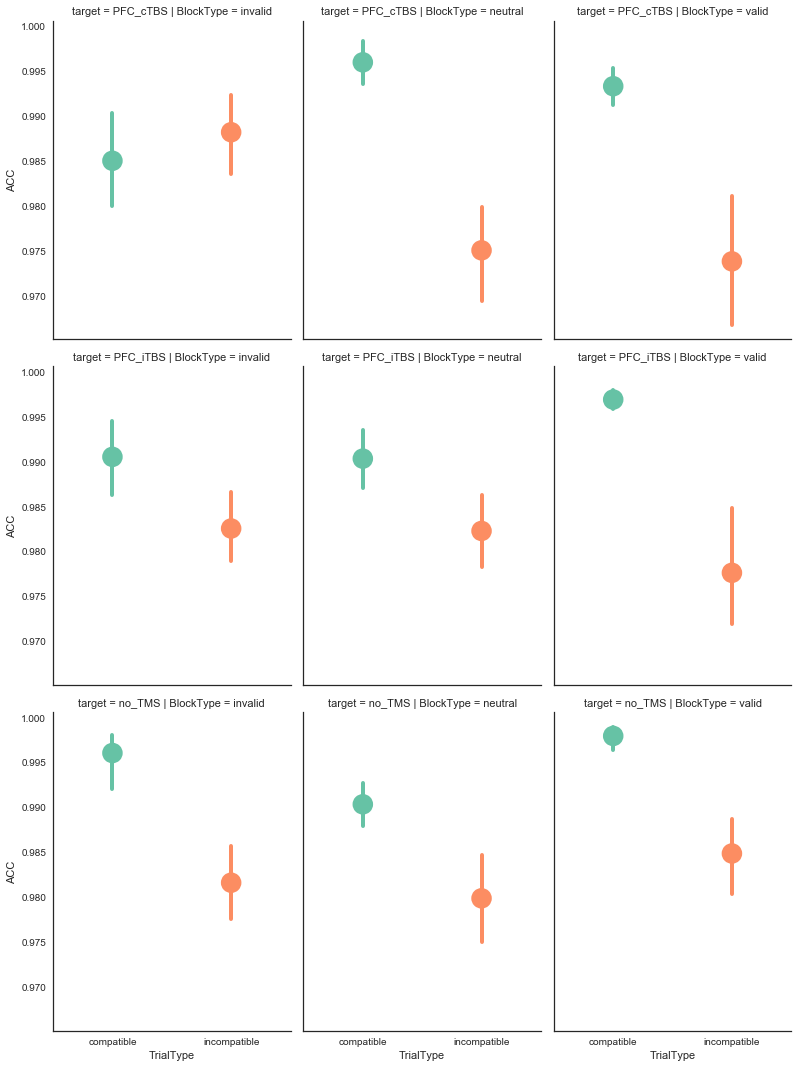

In [58]:
sns.factorplot(x='TrialType', y = 'ACC', col='BlockType', row = 'target', data = group_acc_plot, 
                   palette = 'Set2', kind = 'point', legend = False, 
                   aspect = 0.75, errwidth = 4, size = 5, scale = 2, ci = 68)

In [15]:
# save data for accuracy
#df_w_outliers = df_combined.groupby(['subject', 'target','BlockType', 'TrialType'], as_index=False).aggregate(np.mean)
#df_w_outliers.to_csv('OGWM_TMS_aggregated_w_outliers.csv')

### Report RT measures - begin dropping incorrect trials for motor movement and probe 

In [16]:
error_trials = True

if error_trials == False:
    df_combined = df_combined[(df_combined.ACC == 1) & (df_combined.probeACC == 1)] 
    suffix_2 = 'w_o_errors'
else: 
    df_combined = df_combined[(df_combined.ACC == 1) & (df_combined.probemsecRT != 9999000)] 
    suffix_2 = 'w_errors'

# include only accurate trials, filter out any trials with ACC or probeACC not equal to 1
#df_combined = df_combined[(df_combined.ACC == 1) & (df_combined.probeACC == 1)] 
# include inaccurate trials but exclude nonresponse trials 
#df_combined = df_combined[(df_combined.ACC == 1) & (df_combined.probemsecRT != 9999000)] 

#### Trim subject RT distributions for +/- 3 SD

In [17]:
def trim_outlier_RTs(df_data, DV):
    """
    Loop through subjects incombined dataframe and trim outlierrs +/- 3 SD from mean RT within each subject
    
    df_data: Pandas DataFrame concatenated across subjects 
    DV: dependent variable to trim 
    """
    
    df_combined_trimmed = pd.DataFrame()
    subjects = df_data.subject.unique()
    
    for sub in subjects:
        df_sub = df_data[df_data.subject == sub]
        df_sub_trimmed = trim_outliers_subject(df_sub, DV)
        df_combined_trimmed = pd.concat([df_combined_trimmed, df_sub_trimmed])
        
    print('Original data shape: ', df_data.shape)
    print('Trimmed data shape: ', df_combined_trimmed.shape)
    return df_combined_trimmed 

def trim_outliers_subject(df_sub, DV):
    """
    Within a given subject's data, trim RTs +/- 3 SD from mean RT
    """
    rt_dist = df_sub[DV]
    rt_mean = np.mean(rt_dist)
    rt_std = np.std(rt_dist)
    
    bool_outliers = np.abs(rt_dist - rt_mean) > rt_std*3 # boolean indices for the outliers 
    df_sub_trimmed = df_sub[np.logical_not(bool_outliers)] # keep all data that is NOT outlier 
    
    outliers = rt_dist[np.abs(rt_dist - rt_mean) > rt_std*3]
    print('Outlier {} for subject {}: \n {}\n'.format(DV, df_sub.subject.unique(),outliers))
    #rt_include = rt_dist[np.logical_not(np.absolute(rt_dist - rt_mean) > rt_std*3)]
    
    return df_sub_trimmed 

In [18]:
# Add a movement time parameter
df_combined['movement_time_msecRT'] = df_combined['msecRT'] - df_combined['move_init_bound_msecRT']

/Users/jcbmiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
df_combined_trimmed = trim_outlier_RTs(df_combined, 'move_init_bound_msecRT')
df_combined_trimmed = trim_outlier_RTs(df_combined_trimmed, 'movement_time_msecRT')

Outlier move_init_bound_msecRT for subject ['OGWM_101']: 
 77     1147.0
114    1139.0
144    1163.0
162    1215.0
220    1167.0
285    1257.0
63     1319.0
64     1173.0
93     1231.0
210    1139.0
223    1611.0
278    1163.0
90     1229.0
Name: move_init_bound_msecRT, dtype: float64

Outlier move_init_bound_msecRT for subject ['OGWM_103']: 
 31     1049.0
46      915.0
92       55.0
109    1147.0
179     977.0
203     111.0
204      49.0
322       1.0
1      1020.0
22     1213.0
33      903.0
90      915.0
91      931.0
114     955.0
128     925.0
221     971.0
306      67.0
49      947.0
60      937.0
74      989.0
75     1097.0
197      35.0
229      35.0
266       1.0
313      45.0
Name: move_init_bound_msecRT, dtype: float64

Outlier move_init_bound_msecRT for subject ['OGWM_104']: 
 8      1397.0
32     1647.0
115    1479.0
239    1471.0
300    1383.0
318    1537.0
114    1677.0
149    1471.0
222    1721.0
314    1539.0
151    1387.0
298    1405.0
305    1727.0
Name: move_init_b


Outlier movement_time_msecRT for subject ['OGWM_113']: 
 56     1501.0
99     1407.0
166    1479.0
167    1447.0
221    1367.0
274    1403.0
278    1541.0
203    1459.0
215    1373.0
224    1533.0
227    1464.0
149    1695.0
243    1453.0
270    1419.0
275    1529.0
290    1649.0
Name: movement_time_msecRT, dtype: float64

Outlier movement_time_msecRT for subject ['OGWM_114']: 
 13     1211.0
52     1279.0
256    1273.0
262    1263.0
304    1127.0
226    1111.0
270    1223.0
272    1131.0
316    1093.0
240    1245.0
272    1035.0
290    1357.0
Name: movement_time_msecRT, dtype: float64

Outlier movement_time_msecRT for subject ['OGWM_115']: 
 61     1009.0
88      867.0
190     979.0
0      1120.0
59      941.0
88      989.0
91      983.0
107     965.0
178     929.0
222    1029.0
274    1083.0
282     989.0
316     991.0
21      977.0
56      873.0
80     1055.0
282     933.0
Name: movement_time_msecRT, dtype: float64

Outlier movement_time_msecRT for subject ['OGWM_116']: 
 35     11

In [20]:
# calculate proportion of outlier trials removed 
(df_combined.shape[0] - df_combined_trimmed.shape[0])/df_combined.shape[0]

0.03358361774744027

In [21]:
grouped_subj_TT = df_combined_trimmed.groupby(['subject', 'TrialType'], as_index=False)
grouped_subj_TT_means = grouped_subj_TT.aggregate(np.mean)

### Report RT measures by block types 
### Set DV measure - total RT, movement initiation, movement time, corrected movements

In [22]:
DV = 'move_init_bound_msecRT'
#DV = 'movement_time_msecRT'
#DV = 'msecRT'
#DV = 'correction_proportion'
#DV = 'correction_proportion_1_4'
#DV = 'movement_angle_difference'
#DV = 'movement_angle_difference_1_4'

corrected_movements = True  # True/False to include corrected movements 
corrected_movements_1_4 = True

pal = [(0.40000000000000002, 0.76078431372549016, 0.6470588235294118),
 (0.55294117647058827, 0.62745098039215685, 0.79607843137254897),
           (0.9882352941176471, 0.55294117647058827, 0.3843137254901961)]

In [23]:
print(df_combined_trimmed.shape)

if corrected_movements == False:
    if corrected_movements_1_4 == False:
        df_analyses = df_combined_trimmed[df_combined_trimmed.corrected_movements==0]
    else:
        df_analyses = df_combined_trimmed[df_combined_trimmed.corrected_movements_1_4==0]
    suffix = 'w_o_corrections'
elif corrected_movements == True and corrected_movements_1_4 == False:
    df_analyses = df_combined_trimmed[df_combined_trimmed.corrected_movements_1_4==0]
    suffix = 'w_o_corrections_1_4'
else: 
    df_analyses = df_combined_trimmed
    suffix = 'w_corrections'

    
if corrected_movements_1_4 == True:
    suffix += '_1_4'
    
print(df_analyses.shape)
    
# if corrected_movements_1_4 == False:
#     df_analyses = df_combined_trimmed[df_combined_trimmed.corrected_movements==0]
#     suffix = 'w_o_corrections'
# else: 
#     df_analyses = df_combined_trimmed
#     suffix = 'w_corrections'

(21237, 20)
(21237, 20)


In [24]:
grouped_subj_TT_BT = df_analyses.groupby(['subject','target','TrialType','BlockType'], as_index=False)
grouped_subj_TT_BT_means = grouped_subj_TT_BT.aggregate(np.mean)
grouped_subj_TT_BT_sum = grouped_subj_TT_BT.aggregate(np.sum)

In [25]:
#grouped_subj_TT_BT_means.to_csv('OGWM_TMS_aggregated_mean_no_outliers.csv')

In [26]:
## counts of corrected movements

block_types = df_combined.BlockType.unique()
trial_types = df_combined.TrialType.unique()
target_types = df_combined.TrialType.unique()

import itertools
block_trial_combinations = list(itertools.product(trial_types, block_types, target_types))

subjects = df_combined.subject.unique()

grouped_subj_TT_BT_sum['trial_count'] = np.nan
#trial_counts = np.empty(shape=(len(subjects),len(block_trial_combinations)))

# for i, sub in enumerate(subjects):
#     #print(sub)
#     df_sub = df_combined[df_combined.subject == sub]
#     df_sub_grouped = df_sub.groupby(['TrialType','BlockType']) 
#     for j, combo in enumerate(block_trial_combinations): 
#         df_combo = df_sub_grouped.get_group(combo)
#         trials = df_combo.shape[0]
        
#     df_sub_grouped = df_sub.groupby(['TrialType','BlockType']) 

for index, row in grouped_subj_TT_BT_sum.iterrows():
    
    sub = row.subject
    BT = row.BlockType
    TT = row.TrialType
    target = row.target
    
    df_sub = df_orig[(df_orig.subject == sub)&(df_orig.BlockType == BT)&(df_orig.TrialType == TT)&(df_orig.target == target)]
    trials = df_sub.shape[0]
    
    mask = (grouped_subj_TT_BT_sum.subject==sub)&(grouped_subj_TT_BT_sum.BlockType == BT)&(grouped_subj_TT_BT_sum.TrialType == TT)&(grouped_subj_TT_BT_sum.target == target)
    grouped_subj_TT_BT_sum.loc[mask, 'trial_count'] = trials

    #grouped_subj_TT_BT_sum.loc[index].trial_count = trials 
        
#grouped_subj_TT_BT_sum

In [27]:
# divide number of corrections by number of trials in condition
grouped_subj_TT_BT_sum['correction_proportion'] = grouped_subj_TT_BT_sum['corrected_movements']/grouped_subj_TT_BT_sum['trial_count']
grouped_subj_TT_BT_sum['correction_proportion_1_4'] = grouped_subj_TT_BT_sum['corrected_movements_1_4']/grouped_subj_TT_BT_sum['trial_count']
#grouped_subj_TT_BT_sum.to_csv('OGWM_TMS_aggregated_sum_no_outliers.csv')

### box plot based on DV 

/Users/jcbmiller/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


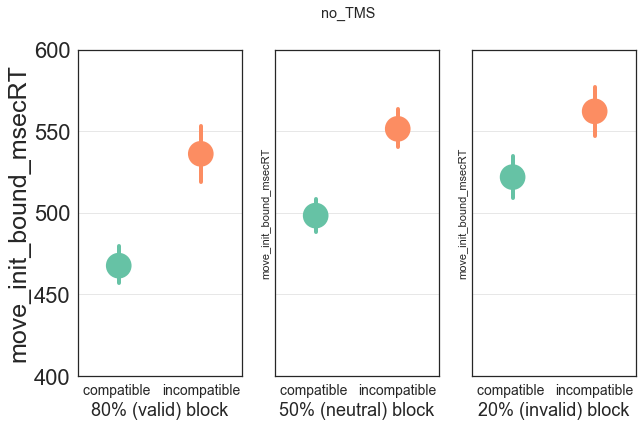

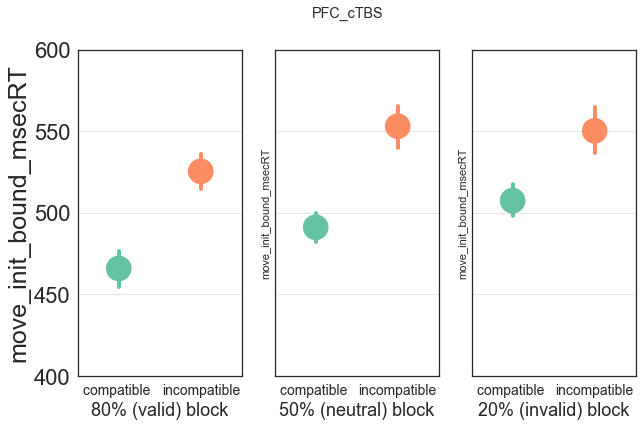

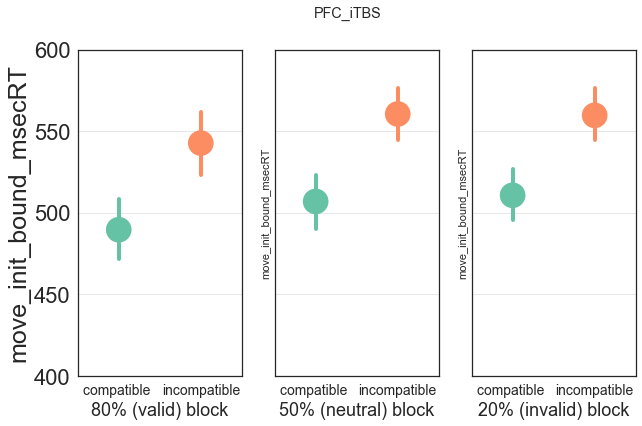

In [28]:
fs = 24
if DV == 'correction_proportion' or DV == 'correction_proportion_1_4': 

    #DV_graph = 'correction_proportion'
    
    data = grouped_subj_TT_BT_sum # use data of SUMS
    
    fig, ax = plt.subplots(1,3, sharey=True, figsize = (15,9)) 

    types = ['valid', 'neutral', 'invalid']
    x_labels = ['80% (valid) block', '50% (neutral) block', '20% (invalid) block']

    for i in range(len(types)):

        # ax1
        #data = data[data.BlockType==types[i]]
        g=sns.factorplot(x='TrialType', y = DV,  row = 'target', data = data.groupby('BlockType').get_group(types[i]), palette = 'Set2', 
                            kind = 'factor',legend = False, size = size, aspect = 0.7, ax = ax[i], ci=95,
                        scale = 1.5,errwidth=4)
        #sns.stripplot(x='TrialType', y = DV_graph,  data = data.get_group(types[i]), alpha = 0.7, size = 7, 
        #              color = 'gray', edgecolor = 'k', linewidth = 2, ax = ax[i])
        # labels 
        #ax[i].plot(0,data.DVs[i],'o')
        ax[i].tick_params(which='both', labelsize=fs-2)
        ax[i].set_xticklabels(['compatible','incompatible'], fontsize = fs + 2)
        ax[i].set_xlabel(x_labels[i], fontsize = fs + 2)
        ax[i].set_ylabel('Proportion of corrected movements', fontsize = fs+1)
        #ax1.set_yticklabels(fontsize = fs - 1)
        # setting ticks 
        ax[i].grid(b=True, which='major', color='k', linewidth=1, axis = 'y', alpha = 0.1)
        ax[i].minorticks_on()
        ax[i].grid(b=True,which='minor', color='k', linewidth=0.5, axis = 'y', alpha = 0.1, linestyle = '--')
        sns.despine(right = False, top = False)
        plt.close(g.fig)
    
else: 
    
    data = grouped_subj_TT_BT_means # use data of MEANS

    for TMS_session in TMS_sessions:
        
        data_session = data[data.target==TMS_session]
        
        fig, ax = plt.subplots(1,3, sharey=True, figsize = (10,6)) 
        plt.ylim(400,600)
        plt.suptitle(TMS_session)

        types = ['valid', 'neutral', 'invalid']
        x_labels = ['80% (valid) block', '50% (neutral) block', '20% (invalid) block']

        for i in range(len(types)):

            g=sns.factorplot(x='TrialType', y = DV, data = data_session[data_session.BlockType==types[i]], palette = 'Set2', 
                            kind = 'point', legend = False, size = size, aspect = 0.7, ax = ax[i], ci=68, 
                            scale = 2.5, errwidth = 4, alpha=1)
            #sns.stripplot(x='TrialType', y = DV,  data = data[data.BlockType==types[i]], alpha = 0.7, size = 7, 
            #              color = 'gray', edgecolor = 'k', linewidth = 2, ax = ax[i])
            # labels 
            #ax[i].plot(0,data.DVs[i],'o')
            ax[i].tick_params(which='both', labelsize=fs-2)
            ax[i].set_xticklabels(['compatible ','incompatible'], fontsize = fs-10)
            ax[i].set_xlabel(x_labels[i], fontsize = fs - 6)
            if i == 0:
                ax[i].set_ylabel(DV, fontsize = fs+1)
            #ax1.set_yticklabels(fontsize = fs - 1)
            # setting ticks 
            ax[i].grid(b=True, which='major', color='k', linewidth=1, axis = 'y', alpha = 0.1)
            #ax[i].minorticks_on()
            #ax[i].grid(b=True,which='minor', color='k', linewidth=0.5, axis = 'y', alpha = 0.1, linestyle = '--')
            sns.despine(right = False, top = False)
            plt.close(g.fig)
            #plt.savefig

            #plt.savefig('OGWM_factorplot_blocktypes_{}_{}_{}.png'.format(DV,suffix,suffix_2), dpi=300)

### difference measures bar plot

/Users/jcbmiller/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


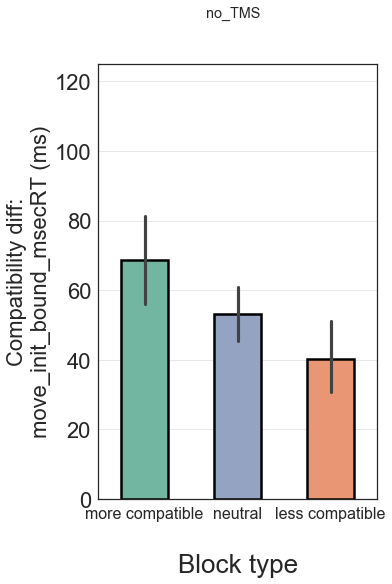

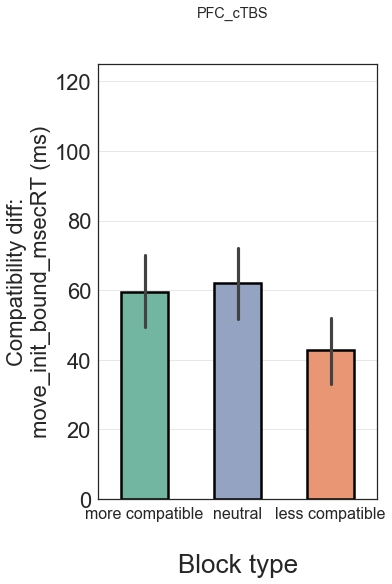

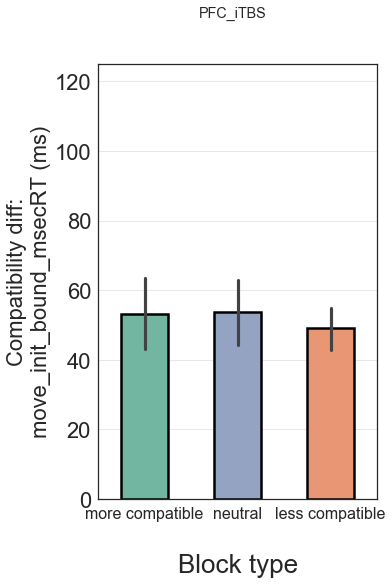

In [29]:
# plot of difference scores by block type 
#data = grouped_subj_TT_BT_means
diffs_no_TMS = pd.DataFrame()
diffs_PFC_cTBS = pd.DataFrame()
diffs_PFC_iTBS = pd.DataFrame()

data_no_TMS = data[data.target=='no_TMS']
data_PFC_cTBS = data[data.target=='PFC_cTBS']
data_PFC_iTBS = data[data.target=='PFC_iTBS']

#pal_dark = ['#4daf4a','#377eb8','#e41a1c']
pal_light = ['#ccebc5','#b3cde3','#fbb4ae']

for i in range(len(types)):
    # get difference scores
    diffs_no_TMS[types[i]] = np.array(data_no_TMS[(data_no_TMS.BlockType==types[i]) & (data_no_TMS.TrialType=='incompatible')][DV]) - np.array(data_no_TMS[(data_no_TMS.BlockType==types[i]) & (data_no_TMS.TrialType=='compatible')][DV]) 
    diffs_PFC_cTBS[types[i]] = np.array(data_PFC_cTBS[(data_PFC_cTBS.BlockType==types[i]) & (data_PFC_cTBS.TrialType=='incompatible')][DV]) - np.array(data_PFC_cTBS[(data_PFC_cTBS.BlockType==types[i]) & (data_PFC_cTBS.TrialType=='compatible')][DV]) 
    diffs_PFC_iTBS[types[i]] = np.array(data_PFC_iTBS[(data_PFC_iTBS.BlockType==types[i]) & (data_PFC_iTBS.TrialType=='incompatible')][DV]) - np.array(data_PFC_iTBS[(data_PFC_iTBS.BlockType==types[i]) & (data_PFC_iTBS.TrialType=='compatible')][DV]) 

    #DV = 'move_init_bound_msecRT'
    
diff_targets = [diffs_no_TMS, diffs_PFC_cTBS, diffs_PFC_iTBS]

for i, diffs in enumerate(diff_targets):
    
    fig, ax = plt.subplots(figsize=(5,8))
    plt.suptitle(TMS_sessions[i])

    # plot total RT diffs 
    if suffix == 'w_o_corrections_1_4':
        pal = pal_light 
    sns.barplot(data=diffs, ax=ax, palette=pal, alpha=1, edgecolor="0", linewidth=2.5,ci=68)

    if DV == 'correction_proportion' or DV == 'correction_proportion_1_4': 
        ax.set_ylim(0,0.25)

    else: 
        ax.set_ylim(0,125)
    #    for i in range(len(types)):
            # plot secondary difference scores 
    #        diffs_2[types[i]] = np.array(data[(data.BlockType==types[i]) & (data.TrialType=='incompatible')]['move_init_bound_msecRT']) - np.array(data[(data.BlockType==types[i]) & (data.TrialType=='compatible')]['move_init_bound_msecRT'])
    #    sns.barplot(data=diffs_2, ax=ax, palette=pal, alpha=1, edgecolor="0",linewidth=2.5, ci=None)

    sns.despine(right = False, top = False)
    ax.grid(b=True, which='major', color='k', linewidth=1, axis = 'y', alpha = 0.1)
    ax.tick_params(which='both', labelsize=fs-2)
    ax.set_xticklabels(['more compatible','neutral','less compatible'], fontsize = fs-8)
    ax.set_xlabel('\nBlock type', fontsize = fs + 2)
    ax.set_ylabel('Compatibility diff:\n{} (ms)'.format(DV), fontsize = fs-2) 

    # Loop over the bars, and adjust the width (and position, to keep the bar centred)
    newwidth = 0.5
    for bar in ax.patches:
        x = bar.get_x()
        width = bar.get_width()
        centre = x+width/2

        bar.set_x(centre-newwidth/2)
        bar.set_width(newwidth)


#sns.stripplot(data=diffs, ax=ax)
#plt.savefig('OGWM_block_barplot_raw_{}_{}_{}.png'.format(DV,suffix,suffix_2), dpi=300,bbox_inches='tight')
#plt.tight_layout()

### testing interaction with rmANOVA

In [31]:
DV_measures = ['move_init_bound_msecRT', 'movement_time_msecRT', 'movement_angle_difference_1_4'] 

# run two-way within subjects ANOVA on each DV 
for DV_measure in DV_measures:
    anvRM = AnovaRM(grouped_subj_TT_BT_means, DV_measure, 'subject', within=['target', 'TrialType', 'BlockType'])
    fit = anvRM.fit()
    print(DV_measure, ': ', suffix_2, suffix)
    print(fit.summary())
    
# run for correction_proportion (which uses SUM data)
DV_measure = 'correction_proportion_1_4'
anvRM = AnovaRM(grouped_subj_TT_BT_sum, DV_measure, 'subject', within=['target', 'TrialType', 'BlockType'])
fit = anvRM.fit()
print(DV_measure, ': ', suffix_2, suffix)
print(fit.summary())

# do one-way ANOVAs and/or t-tests WITHIN each trial type 

move_init_bound_msecRT :  w_errors w_corrections_1_4
                         Anova
                           F Value Num DF  Den DF Pr > F
--------------------------------------------------------
target                      0.4992 2.0000 44.0000 0.6104
TrialType                  51.7943 1.0000 22.0000 0.0000
BlockType                  21.8892 2.0000 44.0000 0.0000
target:TrialType            0.1331 2.0000 44.0000 0.8757
target:BlockType            1.4701 4.0000 88.0000 0.2181
TrialType:BlockType         4.4338 2.0000 44.0000 0.0176
target:TrialType:BlockType  0.9779 4.0000 88.0000 0.4239

movement_time_msecRT :  w_errors w_corrections_1_4
                         Anova
                           F Value Num DF  Den DF Pr > F
--------------------------------------------------------
target                      2.1676 2.0000 44.0000 0.1265
TrialType                  39.6488 1.0000 22.0000 0.0000
BlockType                   0.4241 2.0000 44.0000 0.6570
target:TrialType            2.2080 

/Users/jcbmiller/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


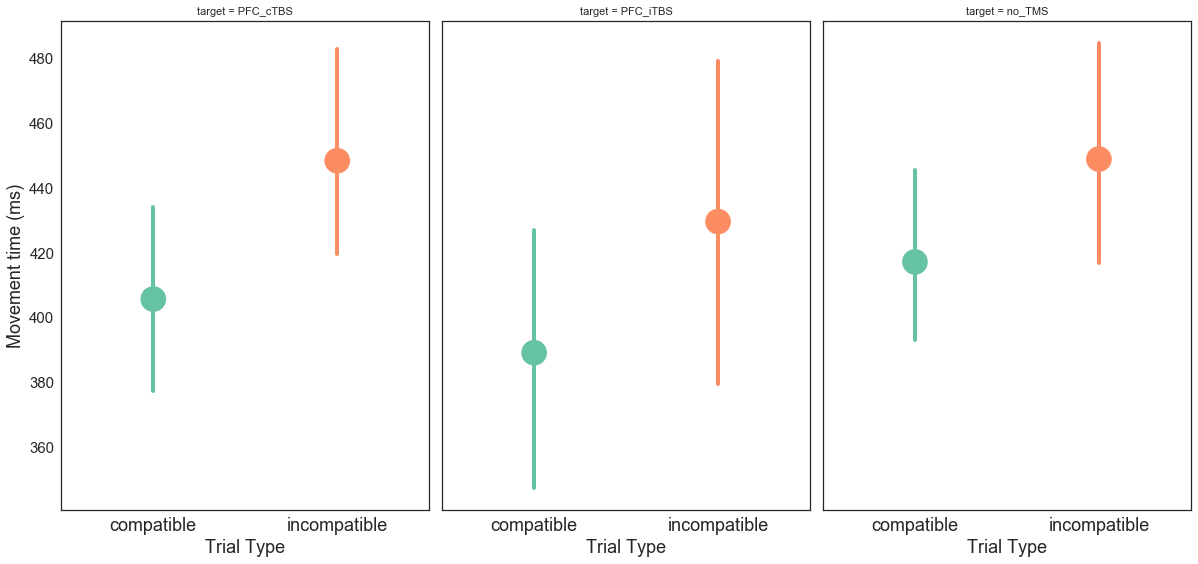

In [32]:
# plot movement RT by TMS type (collapsed across blocks)

size=8
fs=16

group_TMS_plot = df_combined_trimmed.groupby(['subject', 'target','TrialType'], as_index=False).aggregate(np.mean)

#g = sns.factorplot(x='TrialType', y = 'ACC', data = group_acc_plot, palette = 'Set2', kind = 'box', legend = False, size = size, aspect = 0.7, width = 0.4)
#sns.stripplot(x='TrialType', y = 'ACC', data = group_acc_plot, alpha = 0.7, size = 9, color = 'gray', edgecolor = 'k', linewidth = 2)
g = sns.factorplot(x='TrialType', y = 'movement_time_msecRT', col='target',data = group_TMS_plot, palette = 'Set2', kind = 'point', legend = False, 
                   aspect = 0.7, size = size, scale = 2.5, errwidth = 4)

# labels 
g.set_xticklabels(['compatible','incompatible'], fontsize = fs + 2)
g.set_xlabels('Trial Type', fontsize = fs + 2)
g.set_ylabels('Movement time (ms)', fontsize = fs+2)
g.set_yticklabels(fontsize = fs - 1)
# setting ticks 
#plt.grid(b=True, which='major', color='k', linewidth=1, axis = 'y', alpha = 0.3)
plt.tight_layout()
#plt.ylim(0.931,1.0)
#plt.yticks(np.arange(0.93,1,0.1))
#plt.minorticks_on()
#plt.grid(b=True, which='minor', color='k', linewidth=0.5, axis = 'y', alpha = 0.3, linestyle = '--')
sns.despine(right = False, top = False)
#plt.savefig('OGWM_block_boxplot_{}.png'.format(suffix_2), dpi=300)

# # # test difference in accuracy by trial type (across blocks) 
# comp_means = group_acc_plot[group_acc_plot.TrialType=='compatible'].probeACC
# incomp_means = group_acc_plot[group_acc_plot.TrialType=='incompatible'].probeACC

# # # t-test of subbject means for comp vs incomp conditions
# t, p = stats.ttest_rel(comp_means,incomp_means)
# print('T-test of ACC (compatible vs. incompatible subject means): \n t = {0} \n p = {1}'.format(t,p))

In [33]:
grouped_subj_TT = df_analyses.groupby(['subject','target','TrialType'], as_index=False)
grouped_subj_TT_means = grouped_subj_TT.aggregate(np.mean)
grouped_subj_TT_sum = grouped_subj_TT.aggregate(np.sum)

In [34]:
# for just blocks 1-6:
DV_measures = ['move_init_bound_msecRT', 'movement_time_msecRT', 'movement_angle_difference_1_4'] 

# run two-way within subjects ANOVA on each DV 
for DV_measure in DV_measures:
    anvRM = AnovaRM(grouped_subj_TT_means, DV_measure, 'subject', within=['target', 'TrialType'])
    fit = anvRM.fit()
    print(DV_measure, ': ', suffix_2, suffix)
    print(fit.summary())
    
# run for correction_proportion (which uses SUM data)
DV_measure = 'correction_proportion_1_4'
anvRM = AnovaRM(grouped_subj_TT_sum, DV_measure, 'subject', within=['target', 'TrialType'])
fit = anvRM.fit()
print(DV_measure, ': ', suffix_2, suffix)
print(fit.summary())

move_init_bound_msecRT :  w_errors w_corrections_1_4
                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
target            0.6460 2.0000 44.0000 0.5290
TrialType        58.6589 1.0000 22.0000 0.0000
target:TrialType  1.4572 2.0000 44.0000 0.2439

movement_time_msecRT :  w_errors w_corrections_1_4
                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
target            1.6254 2.0000 44.0000 0.2084
TrialType        41.6475 1.0000 22.0000 0.0000
target:TrialType  2.5990 2.0000 44.0000 0.0857

movement_angle_difference_1_4 :  w_errors w_corrections_1_4
                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
target            0.2389 2.0000 44.0000 0.7885
TrialType        53.3546 1.0000 22.0000 0.0000
target:TrialType  2.3581 2.0000 44.0000 0.1064



KeyError: 'correction_proportion_1_4'